# Imports

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy
import datetime as dt
from scipy.stats import pearsonr
import plotly
import plotly.express as px  

from wordcloud import WordCloud, STOPWORDS

# Analysis 1

# How many players are starting their career as baseball players each year

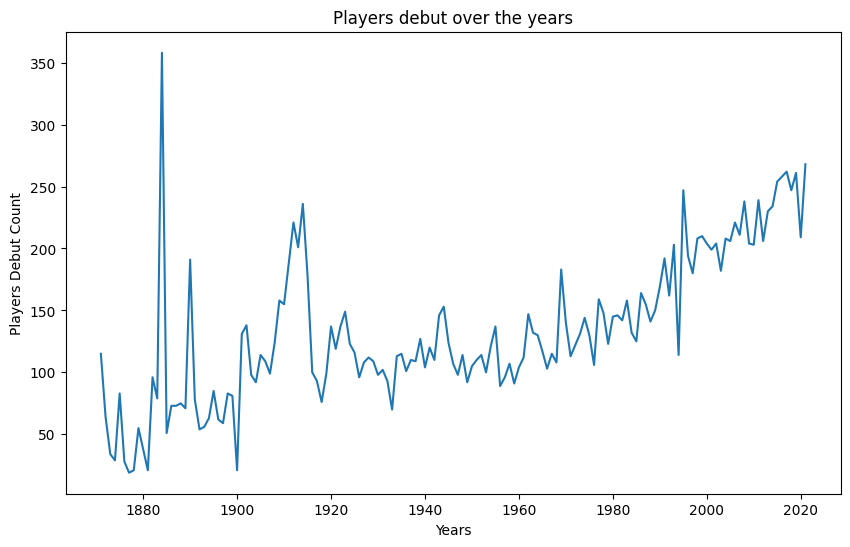

In [54]:
# create dataframe for players information
people = pd.read_csv("baseballdatabank-2022.2/core/People.csv")

# coverting object datatype to the datetime datatype for column debut
people['debut'] = pd.to_datetime(people['debut'])

# creating a column for getting debut year of the players
people['debutyear'] = people['debut'].dt.year

# Replacing the null values with zero
people = people.fillna(0)

# converting the data type from float to int
people['debutyear']= people.debutyear.astype('int64')

# creating a dataframe for getting only required columns
people_debut = people.copy()[['playerID','debutyear','debut']]

# created a new column to the dataframe to assign a count value for players
people_debut['debut_count'] = 1

# grouping the players according to their debut year
group_people = people_debut.groupby('debutyear').sum(numeric_only="True").copy()

# deleting the row of Nan values 
group_people = group_people.drop(labels=0,axis=0,inplace=False)

# plotting a line graph to demonstrate the variation of player debut over the years 
# sns.lineplot('debutyear','debut_count', data = group_people)

#Create and Lineplot
fig, lp = plt.subplots(figsize=(10, 6))
# plot = sns.lineplot(x= group_people['debutyear'] , y=group_people['debut_count'])
# plot = sns.lineplot('debutyear','debut_count', data = group_people)
plot = sns.lineplot(x='debutyear',y='debut_count', data = group_people)
plt.title('Players debut over the years')
plt.xlabel('Years')
plt.ylabel('Players Debut Count')
plt.savefig('graphics/debut_year.pdf', bbox_inches='tight')
plt.show()


# Analysis 2

# From what state of USA most of the baseball players are originated.

In [56]:
# Selecting only required row from the people Dataset that was used in dataset 1
country = people[['playerID','birthCountry','birthState']]

# Cerating a data frame by Grouping the data by country
country_df = country.groupby(by="birthCountry").sum(numeric_only="True").copy()

# sorted the data and have taken the data of USA
country_df = country[country['birthCountry'] == 'USA'].copy()

# added a column "count" and assigning the value of one to it.
country_df['count'] = 1

#  updated the dataframe by grouping the same state data
country_df = country_df.groupby(by="birthState").sum(numeric_only="True").copy()

# reset the index and renamed few columns of the dataframe
country_df = country_df.reset_index()
country_df.rename(columns = {'birthState': 'State', 'count': 'Count'}, inplace = True)

# Ploting USA map
fig = px.choropleth(country_df,  
                    locations="State",  
                    color="Count", 
                    color_continuous_scale="ylorrd",
                    hover_name="State", 
                    locationmode = 'USA-states'
                    )
fig.update_layout(
    title_text = 'In What State Were the Most Number of Professional Baseball Players Born?', 
    geo_scope='usa',
)

fig.write_image('graphics/states_born.pdf')

# Analysis 3

## Number of Players in the MLB Since 1948 by Last School Attended

In [ ]:
#Create dataframes for college playing information and list of schools
college_df = pd.read_csv("baseballdatabank-2022.2/contrib/CollegePlaying.csv")
schools_df = pd.read_csv("baseballdatabank-2022.2/contrib/Schools.csv")

#Save for later analyses
schools_states_df = schools_df.copy().drop(columns=["city", "country", "name_full"])

#Sort college playing information by player, then year
college_df = college_df.sort_values(by=['playerID', 'yearID'], ascending=[False, False])

#Only keep data since from 1948 and after, convert year to string, group each player, and concatenate schoolIDs and years
college_df = college_df[college_df['yearID'] > 1947] 
college_df = college_df.astype({'yearID':'string'})
college_df = college_df.groupby(by="playerID").agg({'schoolID': ' '.join, 'yearID': ' '.join})

#Only want to look at the school that was most recently attended before entering the MLB (so if an athlete has transfered, the first institution attended is ignored)
college_df["schoolID"] = college_df["schoolID"].str.split(" ").str[0]
college_df["yearID"] = college_df["yearID"].str.split(" ").str[0]

#Add a player count column and group columns by the school (to get the number of MLB players from each school)
college_df['player_ct'] = 1
college_df = college_df.groupby(by="schoolID").sum(numeric_only=True)

#Sort colleges by number of players and reset the index
college_df = college_df.sort_values(by=['player_ct'], ascending=[False])
college_df = college_df.reset_index()

#Drop city and country data from schools dataframe and merge with college playing dataframe
schools_df = schools_df.drop(columns=["city", "country"])
college_df = pd.merge(college_df, schools_df)

#Drop the school ID and rename "name_full" column to "school"
college_df = college_df.drop(columns=["schoolID"])
college_df.rename(columns = {'name_full': 'school'}, inplace = True)

#Keep only the top n schools by number of players in the MLB
n = 30
college_n_df = college_df.copy().head(n)

#Create and plot bargraph
fig, ax = plt.subplots(figsize=(10, 6))
plot = sns.barplot(x=college_n_df.school, y=college_n_df['player_ct'])
plt.setp(plot.get_xticklabels(), rotation=90)
plt.title('Top ' + str(n) + ' Schools With the Most Number of Players Who Have Entered the MLB since 1948')
plt.xlabel('Schools')
plt.ylabel('# of Players')
plt.savefig('graphics/schools_to_mlb_barchart.pdf', bbox_inches='tight')
plt.show()

## How many players are entering the MLB from schools in each state?

In [ ]:
#Drop school column to create a new data frame and sum the number of players who came out of a school in each given state
college_states_df = college_df.drop(columns=["school"])
college_states_df = college_states_df.groupby(by="state").sum()

#Reset index and rename columns
college_states_df = college_states_df.reset_index()
college_states_df.rename(columns = {'state': 'State', 'player_ct': 'Player Count'}, inplace = True)

#Fill in Alaska and Montana (no players)
college_states_df.loc[len(college_states_df.index)] = ['AK', 0] 
college_states_df.loc[len(college_states_df.index)] = ['MT', 0] 
college_states_df = college_states_df.sort_values(by=['State'], ascending=[True])
college_states_df = college_states_df.reset_index().drop(columns=["index"])

#Create and plot bargraph
fig, ax = plt.subplots(figsize=(10, 6))
plot = sns.barplot(x=college_states_df.State, y=college_states_df['Player Count'])
plt.setp(plot.get_xticklabels(), rotation=90)
plt.title('Number of Players Entering the MLB from Schools in Each State since 1948')
plt.xlabel('States')
plt.ylabel('# of Players')
plt.savefig('graphics/school_state_to_mlb_barchart.pdf', bbox_inches='tight')
plt.show()

#Plot US heat map
#Needed to increase data rate for this: jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
fig = px.choropleth(college_states_df,  
                    locations="State",  
                    color="Player Count", 
                    hover_name="State", 
                    color_continuous_scale="ylorrd",
                    locationmode = 'USA-states')
fig.update_layout(
    title_text = 'What States are Home to the Schools Sending the Most Players to the MLB?', 
    geo_scope='usa',
)
fig.write_image('graphics/school_state_to_mlb_map.pdf')
fig.show()

# Analysis 4

## Obtain Data

In [ ]:
champs_df = pd.read_csv("baseballdatabank-2022.2/outside_data/ncaa_champs_history.csv")

#Removing covid year and any other year with no champs and make a copy 
champs_df = champs_df[champs_df.runnerup != "--"]
runnerup_df = champs_df.copy()

#Drop columns, so one dataframe has NCAA champions and the other has NCAA runnerups
champs_df = champs_df.drop(columns=["runnerup", "year", "runnerupID"])
runnerup_df = runnerup_df.drop(columns=["champ", "year", "champID"])


#Change column names from champ/runnerup to school and create a title_count column which holds the number of respective titles by school
champs_df.rename(columns = {'champ': 'school', 'champID': 'schoolID'}, inplace = True)
runnerup_df.rename(columns = {'runnerup': 'school', 'runnerupID': 'schoolID'}, inplace = True)
champs_df["title_count"] = 1
runnerup_df["title_count"] = 1

#Get states for each of the schools
champs_df = champs_df.reset_index().drop(columns=["index"])
champs_df = champs_df.merge(schools_states_df, how='left')
runnerup_df = runnerup_df.reset_index().drop(columns=["index"])
runnerup_df = runnerup_df.merge(schools_states_df, how='left')
champs_df = champs_df.groupby("school").agg({'state': 'min', 'title_count': 'sum'})
runnerup_df = runnerup_df.groupby("school").agg({'state': 'min', 'title_count': 'sum'})

#Reset index and sort by number of titles
champs_df = champs_df.reset_index()
runnerup_df = runnerup_df.reset_index()
champs_df = champs_df.sort_values(by=["title_count"], ascending=[False])
runnerup_df = runnerup_df.sort_values(by=["title_count"], ascending=[False])



#Create a dataframe which stores the number of both champion and runnerup titles for each school (remove whitespace), sort by number of titles, reset index
combined_df = pd.concat([champs_df, runnerup_df])
combined_df = combined_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
combined_df["school"].str.strip()
combined_df = combined_df.groupby(by=["school"]).sum(numeric_only=True)
combined_df = combined_df.sort_values(["title_count"], ascending=[False])
combined_df = combined_df.reset_index()

## Champions (number of NCAA championship titles by school)

In [ ]:
#Create and plot barchart
fig, ax = plt.subplots(figsize=(10, 6))
plot = sns.barplot(x=champs_df["school"], y=champs_df['title_count'])
plt.setp(plot.get_xticklabels(), rotation=90)
plt.title('Number of NCAA Championship Titles by School')
plt.xlabel('Schools')
plt.ylabel('# of Titles')
plt.savefig('graphics/school_to_champs_barchart.pdf', bbox_inches='tight')
plt.show()

states_champs_df = champs_df.groupby('state').sum(numeric_only="True").reset_index()

fig = px.choropleth(states_champs_df,  
                    locations="state",  
                    color="title_count", 
                    hover_name="state", 
                    color_continuous_scale="ylorrd",
                    locationmode = 'USA-states')
fig.update_layout(
    title_text = 'What States are Home to the Most Schools Winning NCAA Championships?', 
    geo_scope='usa',
)
fig.write_image('graphics/school_state_to_champs_map.pdf')
fig.show()

## Runnerups (number of NCAA runnerup titles by school)

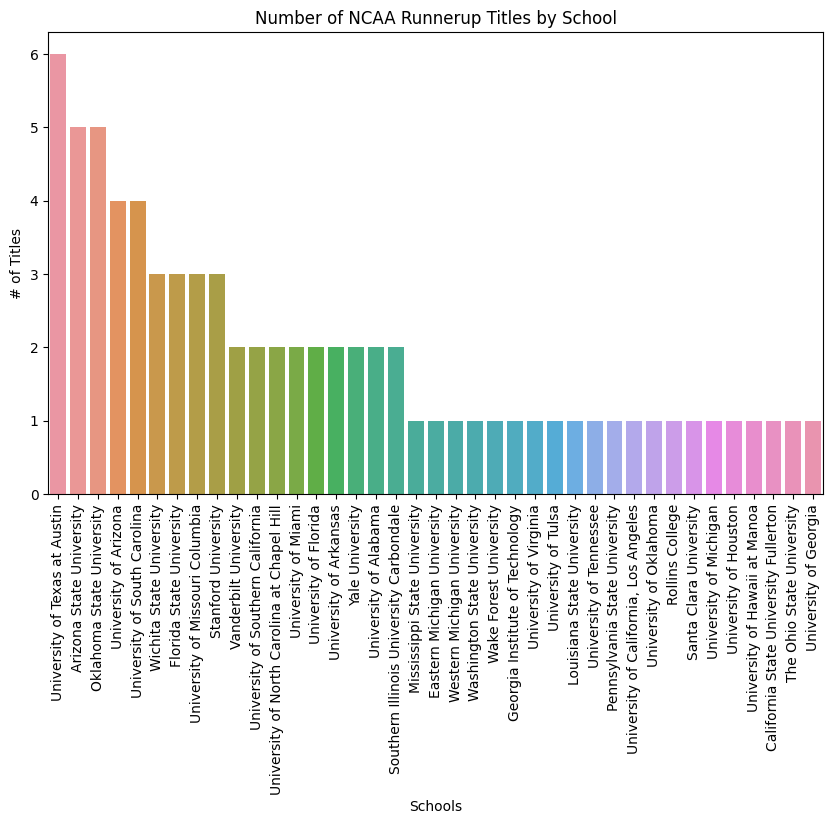

In [57]:
#Create and plot bargraph
fig, ax = plt.subplots(figsize=(10, 6))
plot = sns.barplot(x=runnerup_df["school"], y=runnerup_df['title_count'])
plt.setp(plot.get_xticklabels(), rotation=90)
plt.title('Number of NCAA Runnerup Titles by School')
plt.xlabel('Schools')
plt.ylabel('# of Titles')
plt.savefig('graphics/school_to_runnerup_barchart.pdf', bbox_inches='tight')

plt.show()

states_runnerups_df = runnerup_df.groupby('state').sum(numeric_only="True").reset_index()

fig = px.choropleth(states_runnerups_df,  
                    locations="state",  
                    color="title_count", 
                    hover_name="state", 
                    color_continuous_scale="ylorrd",
                    locationmode = 'USA-states')
fig.update_layout(
    title_text = 'What States are Home to the Most NCAA Championship or Runnerup Titles?', 
    geo_scope='usa',
)
fig.write_image('graphics/school_state_to_runnerup_map.pdf')
fig.show()

## Combined (number of NCAA championship and runnerup titles by school)

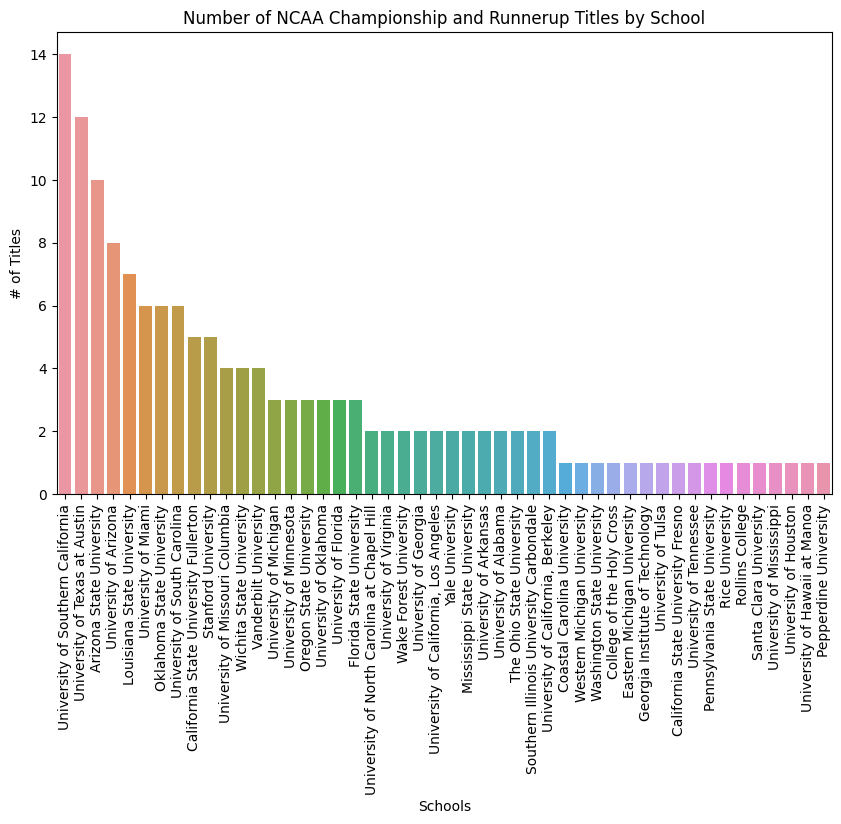

In [58]:
#Create and plot bargraph
fig, ax = plt.subplots(figsize=(10, 6))
plot = sns.barplot(x=combined_df.school, y=combined_df['title_count'])
plt.setp(plot.get_xticklabels(), rotation=90)
plt.title('Number of NCAA Championship and Runnerup Titles by School')
plt.xlabel('Schools')
plt.ylabel('# of Titles')
plt.savefig('graphics/school_to_any_title_barchart.pdf', bbox_inches='tight')
plt.show()



states_both_df = states_runnerups_df.set_index('state').add(states_champs_df.set_index('state'), fill_value=0).reset_index()

fig = px.choropleth(states_both_df,  
                    locations="state",  
                    color="title_count", 
                    hover_name="state", 
                    color_continuous_scale="ylorrd",
                    locationmode = 'USA-states')
fig.update_layout(
    title_text = 'What States are Home to the Most NCAA Championship or Runnerup Titles?', 
    geo_scope='usa',
)
fig.write_image('graphics/school_state_to_any_title_map.pdf')
fig.show()

## Correlation between titles and players entering the MLB

In [ ]:
#Remove states column
school_df = college_df.drop(columns=["state"])

### Champions

In [ ]:
# #Drop tuples column
# winners_df = champs_df.drop(columns=["tuples"])
winners_df = champs_df.copy()

#Merge championship title info with college players info
titles_pros_df = pd.merge(winners_df, school_df)

#Get correlation coefficient
corr, _ = pearsonr(titles_pros_df.title_count, titles_pros_df.player_ct)

#Plot titles vs players sent to mlb
sns.scatterplot(x=titles_pros_df.title_count, y=titles_pros_df.player_ct)
plt.title('Number of NCAA Championship Titles vs Number of Players Entering the MLB')
plt.xlabel('# of Titles')
plt.ylabel('# of Players')
plt.xlim([0, 15])
plt.text(8, 5, 'Pearsons Correlation: %.3f' % corr)
plt.savefig('graphics/champs_vs_mlb_scatter.pdf', bbox_inches='tight')
plt.show()

### Runnerups

In [ ]:
#Drop tuples column
# runnersup_df = runnerup_df.drop(columns=["tuples"])
runnersup_df = runnerup_df.copy()

#Merge runnerup title info with college players info
runnerup_titles_pros_df = pd.merge(runnersup_df, school_df)

#Get correlation coefficient
corr, _ = pearsonr(runnerup_titles_pros_df.title_count, runnerup_titles_pros_df.player_ct)

#Plot titles vs players sent to mlb
sns.scatterplot(x=runnerup_titles_pros_df.title_count, y=runnerup_titles_pros_df.player_ct)
plt.title('Number of NCAA Runnerup Titles vs Number of Players Entering the MLB')
plt.xlabel('# of Titles')
plt.ylabel('# of Players')
plt.xlim([0, 15])
plt.text(8, 5, 'Pearsons Correlation: %.3f' % corr)
plt.savefig('graphics/runnerup_vs_mlb_scatter.pdf', bbox_inches='tight')
plt.show()

### Combined champions and runnerups

In [ ]:
#Drop tuples column
# both_df = combined_df.drop(columns=["tuples"])

both_df = combined_df.copy()

#Merge combined titles info with college players info
combined_titles_pros_df = pd.merge(both_df, school_df)

#Get correlation coefficient
corr, _ = pearsonr(combined_titles_pros_df.title_count, combined_titles_pros_df.player_ct)

#Plot titles vs players sent to mlb
sns.scatterplot(x=combined_titles_pros_df.title_count, y=combined_titles_pros_df.player_ct)
plt.title('Number of NCAA Championship and Runnerup Titles vs Number of Players Entering the MLB')
plt.xlabel('# of Titles')
plt.ylabel('# of Players')
plt.xlim([0, 15])
plt.text(8, 5, 'Pearsons Correlation: %.3f' % corr)
plt.savefig('graphics/any_title_vs_mlb_scatter.pdf', bbox_inches='tight')
plt.show()